# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

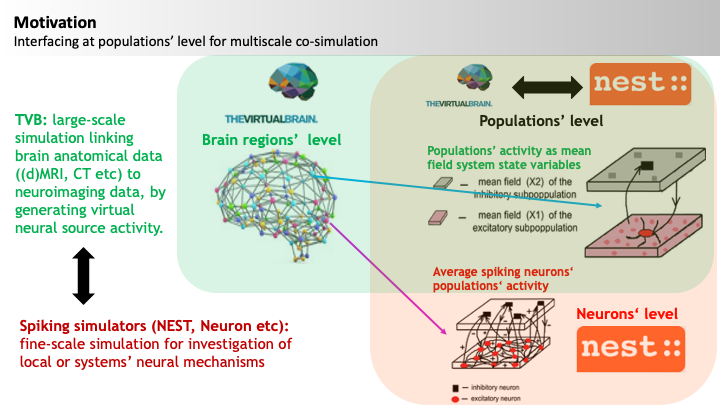

In [1]:
from IPython.core.display import Image, display
display(Image(filename='./ConceptGraph1.png',  width=1000, unconfined=False))

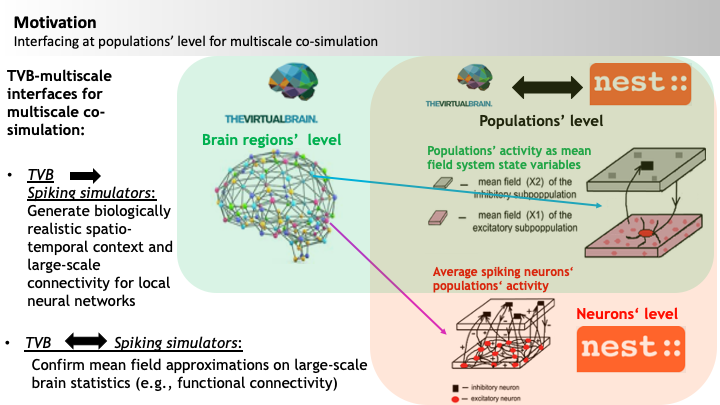

In [2]:
display(Image(filename='./ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

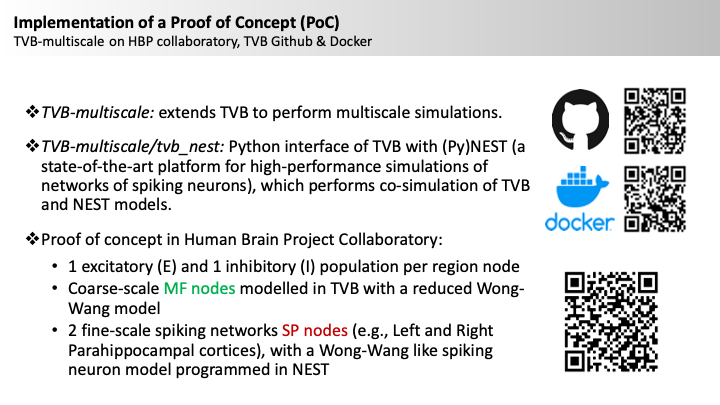

In [3]:
display(Image(filename='./Overview.png',  width=1000, unconfined=False))

# TVB - NEST co-simulation 

## Reduced Wong-Wang TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\dot{S_{n\prime}} = - \frac{1}{\tau}{S_{n\prime}}(t) + (1-{S_{n\prime}}(t))\gamma {R_{n\prime}}(t)$

and $ {R_{n\prime}}(t) $ is the postsynaptic firing rate given by:

$ {R_{n\prime}}(t) = H({I_{syn_{n\prime}}}(t), a, b, d) $

where

$ H({I_{syn_{n\prime}}}(t),  a, b, d) = \frac{aI_{syn_{n\prime}}(t)-b}{1-e^{-d(a{I_{syn_{n\prime}}}(t)-b)}}$ 

is a sigmoidal activation function of the input presynaptic current.

The total input presynaptic current to excitatory populations is given by: 

$ {I_{syn_{n\prime}}}(t) = I_o + w_+J_{N}{S_{n\prime}}(t) + GJ_{N}\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}S_{m\prime}(t-\tau_{{m\prime}{n\prime}})$

## Reduced Wong-Wang mean field model

### Parameters following Deco et al 2013:

- structural TVB connectivity weights $C_{{m\prime}{n\prime}}$ (${m\prime}->{n\prime}$)
- structural TVB connectivity delays $\tau_{{m\prime}{n\prime}}$  (${m\prime}->{n\prime}$)
- global structural brain connectivity coupling constant $G$
- overall effective external input current $I_o = 0.3nA$ 
- excitatory synaptic coupling $J_{N} = 0.2609nA$ 
- local excitatory recurrence $w_+ = 0.9$
- excitatory kinetic parameter $\gamma = 0.641 s$
- excitatory sigmoidal functions parameters $a = 2710nC^{-1}$, $b = 108Hz$, $d = 0.154s$


## Cerebellum Spiking network model in NEST

To be filled in!...

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ interface_{weight} * R(t) $, 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides an auxiliary TVB state variables $R_{in}(t)$, which drives a linear integration equation of another auxiliary TVB state variable $R_{int}(t)$, which,in its turn, acts as a smoothing low pass filter:

$ \dot{R}_{int_{n}}  = -\frac{1}{\tau_{rin_{n}}}(R_{int_{n}}(t) - {R_{in_{n}}}(t)) $


where:

$ {R_{in_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in R_n}}{nNeurons * dt} $ in  spikes/sec.

Finally, $ {R_{int_{n}}}(t) $ overwrites the variable ${R_{n}}(t)$ via a user defined transform function:

${R_{n}}(t) = f_{NEST->TVB}({R_{int_{n}}}(t)) $

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., 4) NEST time steps for every 1 TVB time step for stable integration

In [4]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *
home_path = "/home/docker/packages/tvb-multiscale"
notebooks_path = os.path.join(home_path, "docs/documented_example_notebook")
config = Config(output_base=os.path.join(notebooks_path, "outputs_Cereb"))
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

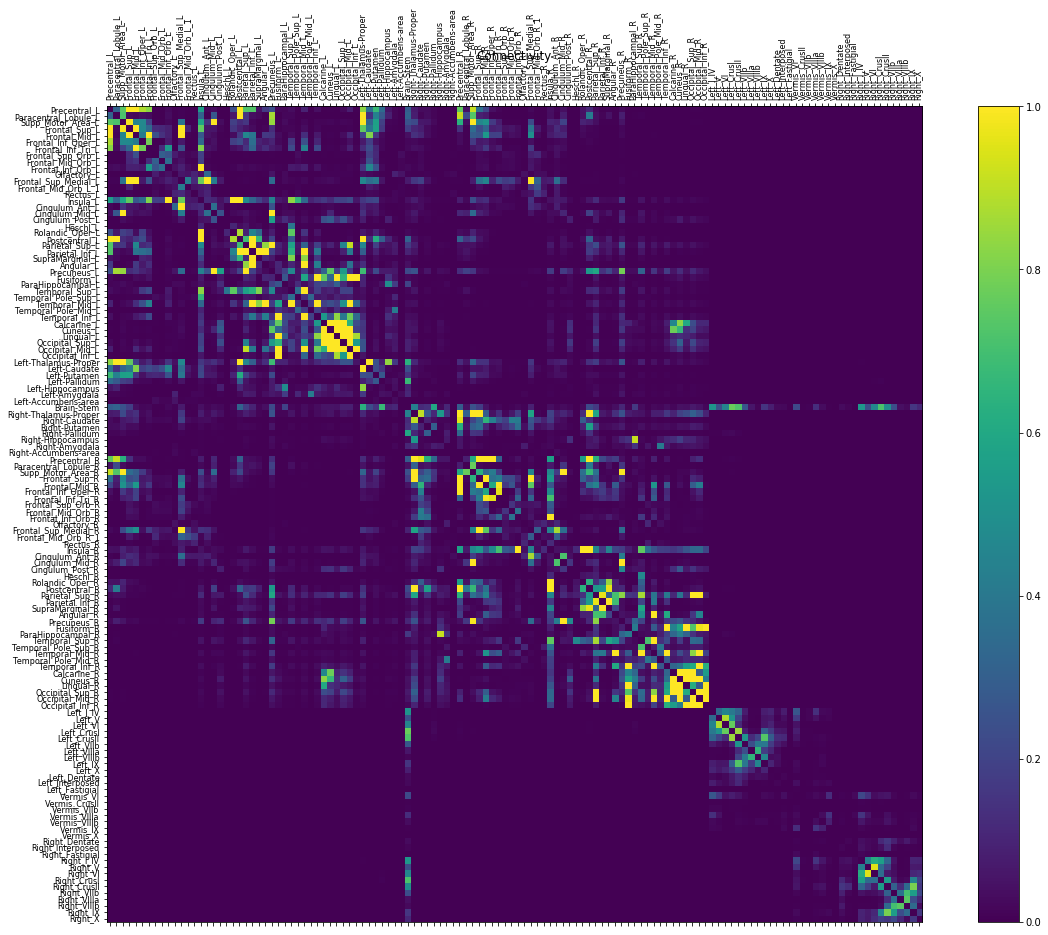

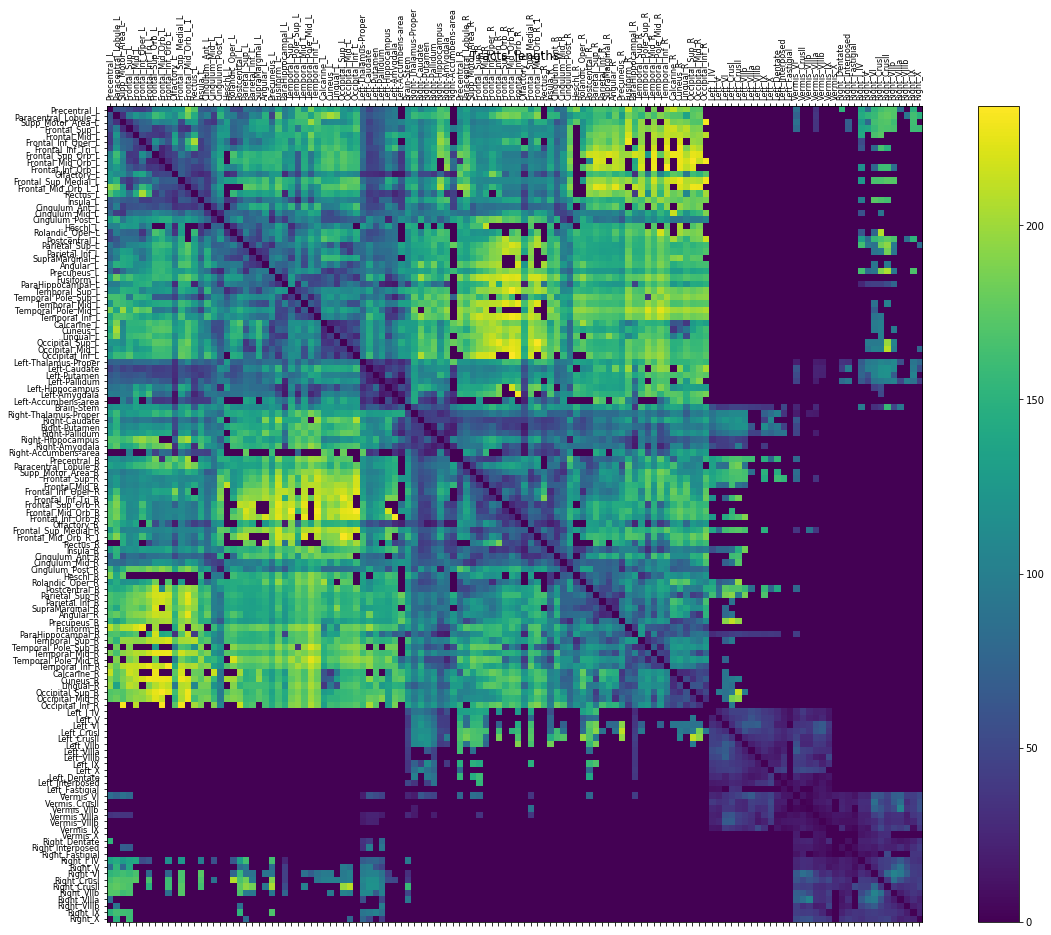

In [5]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG
    
# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)
import os
DATA_PATH = os.path.join(home_path, "examples/tvb_nest/data")
w = np.loadtxt(os.path.join(DATA_PATH, "weights_Count_plusCRBL.txt"))
t = np.loadtxt(os.path.join(DATA_PATH, "tract_lengths_Count_plusCRBL.txt"))
brain_regions_path = os.path.join(DATA_PATH, "centres_brain_MNI.txt")
rl = np.loadtxt(brain_regions_path,dtype="str", usecols=(0,))
c = np.loadtxt(brain_regions_path, usecols=range(1,3))
connectivity=Connectivity(region_labels=rl, weights=w, centres=c, tract_lengths=t)

# Normalize connectivity weights
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
connectivity.weights[connectivity.weights > 1.0] = 1.0

connectivity.configure()
connectivity.speed = np.array([4.0])

#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
model_params = {}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([0.001])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [6]:
# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
nest_nodes_ids = []
for i_region, reg_lbl in enumerate(simulator.connectivity.region_labels):
    if "cereb" in reg_lbl.lower():
        nest_nodes_ids.append(reg_lbl)  # the indices of fine scale regions modeled with NEST
if len(nest_nodes_ids) == 0:
    nest_nodes_ids = [number_of_regions-1]

print(["%d. %s" % (nest_node_id, simulator.connectivity.region_labels[nest_node_id]) for nest_node_id in nest_nodes_ids])


['125. Right_X']


In [7]:
# Build a NEST network model with the corresponding builder
from tvb_multiscale.tvb_nest.nest_models.builders.models.cereb import CerebBuilder

# Using all default parameters for this example
nest_model_builder = CerebBuilder(simulator, nest_nodes_ids, 
                                  os.path.join(DATA_PATH, "cerebellar_cortex_scaffold.hdf5"),
                                  config=config)
nest_model_builder.modules_to_install = ["cereb"]

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default  builder configuration------------------------
# # ----------------------------------------------------------------------------------------------------------------
# import h5py

# # Synapse parameters: in E-GLIF, 3 synaptic receptors are present:
# # the first is always associated to exc,
# # the second to inh,
# # the third to remaining synapse type
# Erev_exc = 0.0  # [mV]	# [Cavallari et al, 2014]
# Erev_inh = -80.0  # [mV]
# # tau_exc for pc is for pf input; tau_exc for goc is for mf input; tau_exc for mli is for pf input:
# tau_exc = {'golgi': 0.23, 'granule': 5.8, 'purkinje': 1.1, 'basket': 0.64, 'stellate': 0.64, 'dcn': 1.0,
#            'dcnp': 3.64,
#            'io': 1.0}
# tau_inh = {'golgi': 10.0, 'granule': 13.61, 'purkinje': 2.8, 'basket': 2.0, 'stellate': 2.0, 'dcn': 0.7,
#            'dcnp': 1.14, 'io': 60.0}
# tau_exc_cfpc = 0.4
# tau_exc_pfgoc = 0.5
# tau_exc_cfmli = 1.2

# # Single neuron parameters:
# nest_model_builder.neuron_param = {
#         'golgi_cell': {'t_ref': 2.0, 'C_m': 145.0, 'tau_m': 44.0, 'V_th': -55.0, 'V_reset': -75.0, 'Vinit': -62.0,
#                        'E_L': -62.0, 'Vmin': -150.0,
#                        'lambda_0': 1.0, 'tau_V': 0.4, 'I_e': 16.214, 'kadap': 0.217, 'k1': 0.031, 'k2': 0.023,
#                        'A1': 259.988, 'A2': 178.01,
#                        'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['golgi'],
#                        'tau_syn2': tau_inh['golgi'], 'tau_syn3': tau_exc_pfgoc},
#         'granule_cell': {'t_ref': 1.5, 'C_m': 7.0, 'tau_m': 24.15, 'V_th': -41.0, 'V_reset': -70.0, 'Vinit': -62.0,
#                          'E_L': -62.0, 'Vmin': -150.0,
#                          'lambda_0': 1.0, 'tau_V': 0.3, 'I_e': -0.888, 'kadap': 0.022, 'k1': 0.311, 'k2': 0.041,
#                          'A1': 0.01, 'A2': -0.94,
#                          'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['granule'],
#                          'tau_syn2': tau_inh['granule'], 'tau_syn3': tau_exc['granule']},
#         'purkinje_cell': {'t_ref': 0.5, 'C_m': 334.0, 'tau_m': 47.0, 'V_th': -43.0, 'V_reset': -69.0, 'Vinit': -59.0,
#                           'E_L': -59.0,
#                           'lambda_0': 4.0, 'tau_V': 3.5, 'I_e': 742.54, 'kadap': 1.492, 'k1': 0.1950, 'k2': 0.041,
#                           'A1': 157.622, 'A2': 172.622,
#                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['purkinje'],
#                           'tau_syn2': tau_inh['purkinje'], 'tau_syn3': tau_exc_cfpc},
#         'basket_cell': {'t_ref': 1.59, 'C_m': 14.6, 'tau_m': 9.125, 'V_th': -53.0, 'V_reset': -78.0, 'Vinit': -68.0,
#                         'E_L': -68.0,
#                         'lambda_0': 1.8, 'tau_V': 1.1, 'I_e': 3.711, 'kadap': 2.025, 'k1': 1.887, 'k2': 1.096,
#                         'A1': 5.953, 'A2': 5.863,
#                         'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['basket'],
#                         'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
#         'stellate_cell': {'t_ref': 1.59, 'C_m': 14.6, 'tau_m': 9.125, 'V_th': -53.0, 'V_reset': -78.0, 'Vinit': -68.0,
#                           'E_L': -68.0,
#                           'lambda_0': 1.8, 'tau_V': 1.1, 'I_e': 3.711, 'kadap': 2.025, 'k1': 1.887, 'k2': 1.096,
#                           'A1': 5.953, 'A2': 5.863,
#                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['basket'],
#                           'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli}}

# # Connection weights
# nest_model_builder.conn_weights = {'mossy_to_glomerulus': 1.0, 'ascending_axon_to_golgi': 0.05, 'ascending_axon_to_purkinje': 0.175,
#                     'basket_to_purkinje': 3.638,
#                     'glomerulus_to_golgi': 0.0125, 'glomerulus_to_granule': 0.361, 'golgi_to_granule': 0.338,
#                     'parallel_fiber_to_basket': 0.002, 'parallel_fiber_to_golgi': 0.008,
#                     'parallel_fiber_to_purkinje': 0.044,
#                     'parallel_fiber_to_stellate': 0.003, 'stellate_to_purkinje': 1.213}

# # Connection delays
# nest_model_builder.conn_delays = \
#     {'mossy_to_glomerulus': 1.0, 'ascending_axon_to_golgi': 2.0, 'ascending_axon_to_purkinje': 2.0,
#      'basket_to_purkinje': 4.0, 'glomerulus_to_golgi': 4.0, 'glomerulus_to_granule': 4.0, 'golgi_to_granule': 2.0,
#      'parallel_fiber_to_basket': 5.0, 'parallel_fiber_to_golgi': 5.0, 'parallel_fiber_to_purkinje': 5.0,
#      'parallel_fiber_to_stellate': 5.0, 'stellate_to_purkinje': 5.0}

# # Connection receptors
# nest_model_builder.conn_receptors = \
#     {'ascending_axon_to_golgi': 3, 'ascending_axon_to_purkinje': 1, 'basket_to_purkinje': 2,
#      'glomerulus_to_golgi': 1, 'glomerulus_to_granule': 1, 'golgi_to_granule': 2,
#      'parallel_fiber_to_basket': 1, 'parallel_fiber_to_golgi': 3, 'parallel_fiber_to_purkinje': 1,
#      'parallel_fiber_to_stellate': 1, 'stellate_to_purkinje': 2}

# # Connection pre and post-synaptic neurons
# nest_model_builder.conn_pre_post = \
#     {'mossy_to_glomerulus': {'pre': 'mossy_fibers', 'post': 'glomerulus'},
#      'ascending_axon_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},
#      'ascending_axon_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},
#      'basket_to_purkinje': {'pre': 'basket_cell', 'post': 'purkinje_cell'},
#      'glomerulus_to_golgi': {'pre': 'glomerulus', 'post': 'golgi_cell'},
#      'glomerulus_to_granule': {'pre': 'glomerulus', 'post': 'granule_cell'},
#      'golgi_to_granule': {'pre': 'golgi_cell', 'post': 'granule_cell'},
#      'parallel_fiber_to_basket': {'pre': 'granule_cell', 'post': 'basket_cell'},
#      'parallel_fiber_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},
#      'parallel_fiber_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},
#      'parallel_fiber_to_stellate': {'pre': 'granule_cell', 'post': 'stellate_cell'},
#     'stellate_to_purkinje': {'pre': 'stellate_cell', 'post': 'purkinje_cell'}}

# nest_model_builder.RECORD_VM = False
# nest_model_builder.TOT_DURATION = 300.  # mseconds
# nest_model_builder.STIM_START = 100.  # beginning of stimulation
# nest_model_builder.STIM_END = 200.  # end of stimulation
# nest_model_builder.STIM_FREQ = 100.  # Frequency in Hz
# nest_model_builder.BACKGROUND_FREQ = 4.

# # Load the network source file:
# nest_model_builder.net_src_file = h5py.File(nest_model_builder.path_to_network_source_file, 'r+')

# # Populations' configurations
# nest_model_builder.neuron_types = list(nest_model_builder.net_src_file['cells/placement'].keys())
# nest_model_builder.populations = []
# nest_model_builder.start_id_scaffold = {}
# # All cells are modelled as E-GLIF models;
# # with the only exception of Glomeruli and Mossy Fibers (not cells, just modeled as
# # relays; i.e., parrot neurons)
# for neuron_name in nest_model_builder.neuron_types:
#     if neuron_name != 'glomerulus' and neuron_name != 'mossy_fibers':
#         model = 'eglif_cond_alpha_multisyn'
#     else:
#         model = 'parrot_neuron'
#     n_neurons = np.array(nest_model_builder.net_src_file['cells/placement/' + neuron_name + '/identifiers'])[1]
#     nest_model_builder.populations.append(
#                 {"label": neuron_name, "model": model,
#                  "params": nest_model_builder.neuron_param.get(neuron_name, {}),
#                  "scale": n_neurons,
#                  "nodes": None})
#     nest_model_builder.start_id_scaffold[neuron_name] = \
#                 np.array(nest_model_builder.net_src_file['cells/placement/' + neuron_name + '/identifiers'])[0]

# # Within brain regions' nodes connections among populations:
# nest_model_builder.default_populations_connection["conn_spec"]["rule"] = "one_to_one"
# nest_model_builder.populations_connections = []
# for conn_name in nest_model_builder.conn_weights.keys():
#     conn = np.array(nest_model_builder.net_src_file['cells/connections/'+conn_name])
#     pre_name = nest_model_builder.conn_pre_post[conn_name]["pre"]
#     post_name = nest_model_builder.conn_pre_post[conn_name]["post"]
#     pre_fun = lambda neurons_inds: [int(x-nest_model_builder.start_id_scaffold[pre_name]+neurons_inds[0])
#                                     for x in conn[:, 0].flatten()]
#     post_fun = lambda neurons_inds: [int(x-nest_model_builder.start_id_scaffold[post_name]+neurons_inds[0])
#                                      for x in conn[:, 1].flatten()]
#     nest_model_builder.populations_connections.append(
#                 {"source": pre_name, "target": post_name,
#                  "source_inds": pre_fun, "target_inds": post_fun,
#                  "model": 'static_synapse',
#                  "conn_spec": nest_model_builder.default_populations_connection["conn_spec"],
#                  "weight": nest_model_builder.conn_weights[conn_name],
#                  "delay": nest_model_builder.conn_delays[conn_name],
#                  "receptor_type": nest_model_builder.conn_receptors.get(conn_name, 0),
#                  "nodes": None
#                  })

# # No among brain region regions' nodes' connectivity yet for the NEST Cerebellum network! 
# # Assuming a single Cerebellum region.

# # We don't need the network source file any more. Close it:
# nest_model_builder.net_src_file.close()

# # Output Devices:
# nest_model_builder.output_devices = []
# # Spike detectors:
# connections = OrderedDict()
# #          label <- target population
# for pop in nest_model_builder.populations:
#     connections[pop["label"] + "_spikes"] = pop["label"]
#     params = dict(nest_model_builder.config.NEST_OUTPUT_DEVICES_PARAMS_DEF["spike_detector"])
#     nest_model_builder.output_devices.append(
#         {"model": "spike_detector", "params": params,
#          "connections": connections, "nodes": None})  # None means all here
# # Multimeters:
# connections = OrderedDict()
# #               label    <- target population
# for pop in nest_model_builder.populations:
#     if pop["label"] != 'glomerulus' and pop["label"] != 'mossy_fibers':
#         connections[pop["label"]] = pop["label"]
#     params = dict(nest_model_builder.config.NEST_OUTPUT_DEVICES_PARAMS_DEF["multimeter"])
#     params["interval"] = nest_model_builder.monitor_period
#     nest_model_builder.output_devices.append(
#             {"model": "multimeter", "params": params,
#              "connections": connections, "nodes": None})  # None means all here
    
# # Input (stimulus) Devices:
# nest_model_builder.input_devices = []
# # Background spike stimulus :
# connections = OrderedDict()
# #             label <- target population
# connections["Background"] = ['glomerulus']
# nest_model_builder.input_devices.append(
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.BACKGROUND_FREQ, 
#                 "origin": 0.0, "start": 0.0}, # not necessary: "stop": nest_model_builder.TOT_DURATION
#      "connections": connections, "nodes": None,
#      "weights": 1.0, "delays": 0.0, "receptor_type": 0})
# # Spike stimulus (needed only when there is no TVB input to the Cerebellum)
# connections = OrderedDict()
# #             label <- target population
# connections["Stimulus"] = ['glomerulus']
# nest_model_builder.input_devices.append(
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.STIM_FREQ, "origin": 0.0, 
#                 "start": nest_model_builder.STIM_START, "stop": nest_model_builder.STIM_END},
#      "connections": connections, "nodes": None,
#      "weights": 1.0, "delays": 0.0, "receptor_type": 0})

# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------


nest_network = nest_model_builder.build_spiking_network()


2020-09-02 17:11:27,939 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-09-02 17:11:27,939 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-09-02 17:11:27,942 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-09-02 17:11:27,942 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-09-02 17:11:27,946 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-09-02 17:11:27,946 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-09-02 17:11:27,948 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2020-09-02 17:11:27,948 - INFO - tvb_multiscale.t

2020-09-02 17:11:27,964 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - system path: ['/home/docker/env/neurosci/nest_build/lib/python3.7/site-packages', '/home/docker/packages/tvb-multiscale/docs/documented_example_notebook', '/home/docker/env/neurosci', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/docker/env/neurosci/lib/python3.7/site-packages', '/home/docker/env/neurosci/lib/python3.7/site-packages/NESTML-3.1.post0.dev0-py3.7.egg', '/home/docker/env/neurosci/lib/python3.7/site-packages/typing-3.7.4.1-py3.7.egg', '/home/docker/env/neurosci/lib/python3.7/site-packages/sympy-1.6-py3.7.egg', '/home/docker/env/neurosci/lib/python3.7/site-packages/odetoolbox-2.0-py3.7.egg', '/home/docker/env/neurosci/lib/python3.7/site-packages/astropy-2.0.3-py3.7-linux-x86_64.egg', '/home/docker/env/neurosci/lib/python3.7/site-packages/antlr4_python3_runtime-4.8-py3.7.egg', '/home/docker/env/neurosci/lib/python3.7/site-packages/mpmath-1.1.0-py3

2020-09-02 17:11:28,327 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for basket_cell_spikes created!
2020-09-02 17:11:28,356 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for glomerulus_spikes created!
2020-09-02 17:11:28,356 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for glomerulus_spikes created!
2020-09-02 17:11:28,378 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for golgi_cell_spikes created!
2020-09-02 17:11:28,378 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for golgi_cell_spikes created!
2020-09-02 17:11:28

In [8]:
if "nest_model_builder" in globals():
    populations_sizes = []
    print("Population sizes: ")
    for pop in nest_model_builder.populations:
        populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
        print("%s: %d" % (pop["label"], populations_sizes[-1]))
if "nest_network" in globals():
    print(nest_network.print_str(connectivity=True))
else:
    nest_network = None

Population sizes: 
basket_cell: 52
glomerulus: 1012
golgi_cell: 30
granule_cell: 12192
mossy_fibers: 50
purkinje_cell: 35
stellate_cell: 113

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
NESTNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['Right_X']
Regions' nodes:

----------------------------------------------------------------------------------------------------
NESTRegionNode - Label: Right_X
Populations ['basket_cell', 'glomerulus', 'golgi_cell', 'granule_cell', 'mossy_fibers', 'purkinje_cell', 'stellate_cell']:

----------------------------------------------------------------------------------------------------

NESTPopulation - Label: b

## 3. Build the TVB-NEST interface

In [9]:
from tvb_multiscale.tvb_nest.interfaces.builders.models.red_ww_cereb import RedWWexcIOBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    RedWWexcIOBuilder(simulator, nest_network, nest_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_nest_mode = None # "rate"
nest_to_tvb = False

# Using all default parameters for this example

# or...


# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------


# # TVB -> NEST


# # --------For spike transmission from TVB to NEST devices acting as TVB proxy nodes with TVB delays:--------

# tvb_nest_builder.G = tvb_nest_builder.tvb_simulator.model.G[0].item()
# tvb_nest_builder.global_coupling_scaling = tvb_nest_builder.tvb_simulator.coupling.a[0].item() * tvb_nest_builder.G
    
# tvb_weight_fun = \
#     lambda source_node, target_node: \
#                  scale_tvb_weight(source_node, target_node, 
#                                   tvb_nest_builder.tvb_weights, scale=tvb_nest_builder.global_coupling_scaling)

# tvb_delay_fun = \
#     lambda source_node, target_node: \
#         np.maximum(tvb_nest_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_nest_builder.tvb_delays))

# tvb_nest_builder.tvb_to_nest_interfaces = []
# if tvb_to_nest_mode == "rate":
#     # Mean spike rates are applied in parallel to all target neurons

#     tvb_nest_builder.tvb_to_nest_interfaces.append(
#             {"model": "inhomogeneous_poisson_generator",
#              "params": {"allow_offgrid_times": False},
#         # # ---------Properties potentially set as function handles with args (nest_node_id=None)-------------------------
#              "interface_weights": 5.0, 
#         # Applied outside NEST for each interface device
#         # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)-----------
#             "weights": lambda tvb_node_id, nest_node_id: tvb_weight_fun(tvb_node_id, nest_node_id),
#             "delays": lambda tvb_node_id, nest_node_id: tvb_delay_fun(tvb_node_id, nest_node_id),
#             "receptor_type": 0,
#             # --------------------------------------------------------------------------------------------------------------
#             #             TVB sv -> NEST population
#             "connections": {"R": "mossy_fibers"},
#             "source_nodes": None, "target_nodes": None})  # None means all here
    
# if nest_to_tvb:
#     tvb_nest_builder.nest_to_tvb_interfaces = []
#     # TVB <-- NEST:
#     # Use S_e and S_i instead of r_e and r_i
#     # for transmitting to the TVB state variables directly
#     connections = OrderedDict()    
#     #            TVB <- NEST
#     connections["Rin"] = "purkinje_cell"
#     tvb_nest_builder.nest_to_tvb_interfaces.append(
#             {"model": "spike_detector", "params": {},
#         # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
#              "weights": 1.0, "delays": 0.0,
#         # -----------------------------------------------------------------------------------------------------------------
#              "connections": connections, "nodes": None})  # None means all here

# tvb_nest_builder.w_tvb_to_spike_rate = 1.0
# # We return from a NEST spike_detector the ratio number_of_population_spikes / number_of_population_neurons
# # for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# # as long as a neuron cannot fire twice during a TVB time step, i.e.,
# # as long as the TVB time step (usually 0.001 to 0.1 ms)
# # is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
# tvb_nest_builder.w_spikes_to_tvb = 1000.0

# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)

2020-09-02 17:11:34,446 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-09-02 17:11:34,446 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-09-02 17:11:34,449 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-09-02 17:11:34,449 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!


In [10]:
if "tvb_nest_model" in globals():
    print(tvb_nest_model.print_str(detailed_output=True, connectivity=False))
else:
    tvb_nest_model = None


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
RedWWexcIO TVB-NEST Interface




## 4. Configure simulator, simulate, gather results

In [11]:
# Set the simulation and transient (to be optionally removed from resutls) times:
simulation_length=300.0
transient = 0.0
if transient:
    exclude_times = [0.0, transient]
else:
    exclude_times = []

In [ ]:
# Configure the simulator with the TVB-NEST interface...
# ...and simulate!
tic = time.time()
if tvb_nest_model is None:
    nest_network.nest_instance.Prepare()
    # Integrate NEST for simulation_length + 1 NEST time step so that multimeters get the last time point
    # unless you plan to continue simulation later
    nest_network.nest_instance.Run(simulation_length + nest_network.nest_instance.GetKernelStatus("resolution"))
    nest_network.nest_instance.Cleanup()
    results = None
else:
    simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
    results = simulator.run(simulation_length=simulation_length)
    # Integrate NEST for one more NEST time step so that multimeters get the last time point
    # unless you plan to continue simulation later
    simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
    # Clean-up NEST simulation
    simulator.tvb_spikeNet_interface.nest_instance.Cleanup()
print("\nSimulated in %f secs!" % (time.time() - tic))

## 5. Plot results and write them to HDF5 files

In [ ]:
# Do everything using plot_write_results function or move to the next cell...
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, spiking_network=nest_network, spiking_nodes_ids=nest_nodes_ids,
#.                   populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables",
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, plotter=plotter, config=config)

In [ ]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

### 5a. TVB results


In [ ]:
source_ts = None
if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    # Remove transient, if any
    if transient:
        source_ts = source_ts[transient:]
        exclude_times = [0.0, transient]
    else:
        exclude_times = []
    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    source_ts
    

In [ ]:
if source_ts is not None:
    # Plot TVB time series
    source_ts.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

In [ ]:
if source_ts is not None:
    # TVB time series raster plot:
    if source_ts.number_of_labels > 9:
        source_ts.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

### Interactive time series plot

In [ ]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

In [ ]:
# Focus on the nodes modelled in NEST:
try:
    tvb_nest_model = simulator.tvb_spikeNet_interface
except:
    pass
source_ts_nest = None
if tvb_nest_model is not None:
    n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
    source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
    source_ts_nest.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
                                   figname="Spiking nodes TVB Time Series");


In [ ]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts_nest is not None:
    source_ts_nest.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
                               figname="Spiking nodes TVB Time Series Raster");

### 5b. Results of TVB-NEST interface

### Plot population mean membrane potential time series

In [ ]:
%matplotlib inline 
if tvb_nest_model is not None:
    tic = time.time()
    # Plot NEST multimeter variables
    # Get continuous state variables from NEST via interfaces to NEST multimeter devices
    # Get them directly as mean field quantities..
    multimeter_mean_data = \
        simulator.tvb_spikeNet_interface.get_mean_data_from_multimeter_to_TimeSeries(connectivity=simulator.connectivity)
    if transient:
        multimeter_mean_data = multimeter_mean_data[transient:]
    if multimeter_mean_data is not None and multimeter_mean_data.size > 0:
         plotter.plot_multimeter_timeseries(multimeter_mean_data, plot_per_variable=True,
                                            time_series_class=TimeSeriesXarray, time_series_args={},
                                            var_pop_join_str=" - ", default_population_label="population",
                                            figname="NEST region time series");
    if n_spiking_nodes > 3:
        plotter.plot_multimeter_raster(multimeter_mean_data, plot_per_variable=True,
                                       time_series_class=TimeSeriesXarray, time_series_args={},
                                       var_pop_join_str=" - ", default_population_label="population",
                                       figname="NEST region time series raster");
    print("\nRecovered and plotted TVB-NEST interface results in %f secs!" % (time.time() - tic))
    

### Plot spikes' raster and mean spike rate for NEST regions

In [ ]:
# Plot spikes and mean field spike rates time series
# TOO SLOW FOR THE MOMENT!
# if tvb_nest_model is not None:
#     tic = time.time()
#     mf_rates_ts, spike_detectors = \
#             simulator.tvb_spikeNet_interface.get_mean_spikes_rates_to_TimeSeries(
#                 spikes_kernel_width=1.0,  # ms
#                 spikes_kernel_overlap=0.5, time=t, connectivity=simulator.connectivity)
#     if spike_detectors is not None and mf_rates_ts.size > 0:
#         plotter.plot_spike_detectors(spike_detectors, rates=mf_rates_ts, title='Population spikes and mean spike rate');
#      print("\nRecovered and plotted TVB-NEST interface mean field rate results in %f secs!" % (time.time() - tic))
    

### 5c. Results of NEST network
### Get per neuron NEST time series and plot them, as well as mean quantities

In [ ]:
from xarray import DataArray
from tvb.contrib.scripts.utils.data_structures_utils import concatenate_heterogeneous_DataArrays
spiking_network = None
try:
    spiking_network = simulator.tvb_spikeNet_interface.spiking_network
except:
    spiking_network = nest_network
    n_spiking_nodes = len(nest_model_builder.nest_nodes_ids)

nest_ts = None
# TOO SLOW FOR THE MOMENT!
if spiking_network is not None:
    tic = time.time()
    # Time Series
    nest_ts = spiking_network.get_data_from_multimeter(mode="per_neuron")
    if not isinstance(nest_ts, DataArray):
        # assuming a pandas Series due to heterogeneity of populations in among brain regions:
        nest_ts = concatenate_heterogeneous_DataArrays(nest_ts, "Population",
                                                       transpose_dims=["Time", "Variable", 
                                                                       "Region", "Population", "Neuron"])
    nest_ts = TimeSeriesXarray(nest_ts, connectivity=simulator.connectivity)
    if transient:
        nest_ts = nest_ts[transient:]
    if n_spiking_nodes <= 3:
        nest_ts.plot_map(y=nest_ts._data.dims[4], row=nest_ts._data.dims[2], col=nest_ts._data.dims[3],
                         per_variable=True,  cmap="jet", figsize=FIGSIZE, plotter_config=plotter.config);


In [ ]:
# Compute mean field
if nest_ts is not None:
    ts = TimeSeriesXarray(nest_ts._data.mean(axis=-1), connectivity=nest_ts.connectivity,
                          title="Mean field spiking nodes time series")
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(ts._data, connectivity=ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, ts.title)+".h5", recursive=False)
    # Plot mean field
    ts.plot_timeseries(plotter_config=plotter.config, per_variable=True)
    if n_spiking_nodes > 3:
        ts.plot_raster(plotter_config=plotter.config, per_variable=True, linestyle="--", alpha=0.5, linewidth=0.5);
    print("\nRecovered and plotted NEST results in %f secs!" % (time.time() - tic))
    

In [ ]:
nest_spikes = None
if spiking_network is not None:
    from xarray import DataArray, concat

    tic = time.time()
    
    # Spikes
    nest_spikes = spiking_network.get_spikes(mode="events", return_type="Series", exclude_times=exclude_times)
    if writer:
        writer.write_object(nest_spikes.to_dict(), path=os.path.join(config.out.FOLDER_RES,  "NEST_Spikes") + ".h5")

    # Compute mean spike rates
    spike_rates = []
    if "t" in globals() and nest_ts is not None:
        t = nest_ts.time
        duration = (t[-1] - t[0])
    else:
        duration = simulation_length - transient
    duration  /= 1000   # in sec
    for i_pop, (pop_label, pop_spikes) in enumerate(nest_spikes.iteritems()):
        spike_rates.append([])
        reg_labels = []
        for reg_label, reg_spikes in pop_spikes.iteritems():
            reg_labels.append(reg_label)
            # rates (spikes/sec) =
            #   total_number_of_spikes (int) / total_time_duration (sec) / total_number_of_neurons_in_pop (int)
            spike_rates[-1].append(len(reg_spikes["times"]) / duration / populations_sizes[i_pop])
        spike_rates[-1] = np.array(spike_rates[-1])
        while spike_rates[-1].ndim < 2:
            spike_rates[-1] = spike_rates[-1][np.newaxis]
        spike_rates[-1] = DataArray(np.array(spike_rates[-1]), 
                                    dims=["Population", "Region"], name="NEST_spike_rates",
                                    coords={"Population": [pop_label], "Region": reg_labels})
    spike_rates = concat(spike_rates, spike_rates[-1].dims[0], fill_value=np.nan)
    print(spike_rates)
    if writer:
        writer.write_object(spike_rates.to_dict(), path=os.path.join(config.out.FOLDER_RES, spike_rates.name) + ".h5")

In [ ]:
# Plot spikes
if nest_spikes is not None:
    plotter.plot_spike_events(nest_spikes, figsize=FIGSIZE);
    print("\nRecovered and plotted NEST spikes and computed spike rates in %f secs!" % (time.time() - tic))

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>